## Orbits in Kerr Spacetime
Here, we will develop a code that integrate particle and photon orbits in a Kerr spacetime. This will be an object-oriented approach, with objects such as "black hole," "photon," and "particle." This is very simplistic; we do not employ attempt to solve the EFE for arbitrary metrics, etc. but focus on geodesics in Kerr (and Schwarzschild, $a = 0$) metrics. Additionally, we include an option to animate the orbits and store them as .gif for future use.

Note: All quantities are dimensionless, as we use natural units where $G$ = $c$ = 1. 

In [ ]:
# Imports 
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

from scipy.integrate import solve_ivp

import os

In [4]:
# Decorators for adding attributes to class methods 
def add_event_attr(terminal = True, direction = 0):
    def decorator(func):
        func.terminal = terminal
        func.direction = direction
        return func
    return decorator

In [5]:
# Black Hole Object
class BlackHole:
    def __init__(self, mass = 1, spin = 0, r = 0, theta = 0, phi = 0):
        self.M = mass
        self.a = spin
        self.r = r
        self.theta = theta
        self.phi = phi

        self.r_evt = self.M + np.sqrt(self.M**2 - self.a**2) # event horizon

    def __repr__(self):
        return f"Black Hole Object with M = {self.mass}, a = {self.spin}, (r, theta, phi) = ({self.r}, {self.theta}, {self.phi})"

In [165]:
# Particle Object
class Particle:
    def __init__(self, E = 1, l = 0, Q = 0, r = 0, theta = np.pi/2, phi = 0, t = 0, sign_r = -1, sign_theta = 1, BH = BlackHole()):
        """Initializes a Particle Object with the following parameters:"""
       
        """E = Energy
        l = Angular Momentum
        Q = Carter Constant
        pos = [r, theta, phi, t] = initial coordinates of the particle
        BH = Black Hole Object around which the particle will orbit
        sign_r = -1 for ingoing, 1 for outgoing (initial r direction or orbit)
        sign_theta = -1 for decreasing, 1 for increasing (initial theta direction or orbit)"""

        self.E = E 
        self.l = l 
        self.Q = Q 

        self.BH = BH 

        self.r = r
        self.theta = theta
        self.phi = phi
        self.t = t
        self.pos = np.array([r, theta, phi, t])

        self.sign_r = sign_r
        self.sign_theta = sign_theta
        
        self.flag_theta = False # are we allowing orbits out of the plane?

        if theta != np.pi/2 and BH.a != 0:
            self.flag_theta = True

    def __repr__(self):
        return f"Particle Object with E = {self.E}, l = {self.l}, Q = {self.Q}, (r, theta, phi) = ({self.r}, {self.theta}, {self.phi})"
    
    def __sigma(self, pos):
        """returns: sigma from Kerr metric"""
        a = self.BH.a

        r = pos[0]
        theta = pos[1]

        return r**2 + a**2 * np.cos(theta)**2
    
    def __delta(self, pos):
        """returns: delta from Kerr metric"""
        M = self.BH.M
        a = self.BH.a

        r = pos[0]

        return r**2 - 2*M*r + a**2
    
    def t_dot(self, pos):
        """pos = [r, theta, phi, t] = current coordinates of the particle
        returns: t_dot from the geodesic equations"""

        E = self.E
        l = self.l

        M = self.BH.M
        a = self.BH.a

        r = pos[0]
        theta = pos[1]

        num = E*(self.__sigma(pos)*(r**2 + a**2) + 2*M*r*(a**2)*np.sin(theta)**2) - 2*a*M*r*l
        den = (self.__sigma(pos) - 2*M*r)*(r**2 + a**2) + 2*M*r*(a**2)*np.sin(theta)**2
        return num/den
    
    def phi_dot(self, pos):
        """pos = [r, theta, phi, t] = current coordinates of the particle
        returns: phi_dot from the geodesic equations"""

        E = self.E
        l = self.l

        M = self.BH.M
        a = self.BH.a

        r = pos[0]
        theta = pos[1]

        num = 2*a*M*r*E*(np.sin(theta)**2) + (self.__sigma(pos) - 2*M*r)*l
        den =  (self.__sigma(pos) - 2*M*r)*(r**2 + a**2)*np.sin(theta)**2 + 2*M*r*(a**2)*np.sin(theta)**4
        return num/den
    
    def theta_dot(self, pos):
        """pos = [r, theta, phi, t] = current coordinates of the particle
        returns: theta_dot from the geodesic equations"""
        if self.flag_theta == True:
            E = self.E
            l = self.l
            Q = self.Q

            M = self.BH.M
            a = self.BH.a

            r = pos[0]
            theta = pos[1]

            num = Q + (a**2)*(E - 1)*np.cos(theta)**2 - (l**2)*(1/np.tan(theta)**2)
            den = self.__sigma(pos)**2
            
            thetadot2 = num/den
            return self.sign_theta * np.sqrt(np.abs(thetadot2)), thetadot2
        else:
            return 0, 0 # must return two things to match the other return statement
        
    def r_dot(self, pos):
        """pos = [r, theta, phi, t] = current coordinates of the particle
        returns: r_dot from the geodesic equations"""

        M = self.BH.M
        a = self.BH.a
        Q = self.Q
        E = self.E
        l = self.l

        e = E**2 - E

        r = pos[0]
        theta = pos[1]

        term_1 = 2*(r**2 + (a**2)*np.cos(theta)**2)**2
        term_2 = -2*Q*a**2 + 2*e*(a**4)*np.cos(theta)**2
        term_3 = (3*e + 2*E - 2)*a**2 - 2*(l**2 + Q) + e*(a**2)*np.cos(2*theta)
        term_4 = 4*M*r**3 + 2*(r**4)*(e + E -1)
        term_5 = a*E*(a - 2*l) + l**2 + Q + e*(a**2)*np.sin(theta)**2

        rdot2 = (term_2 + term_3*r**2 + term_4 + 4*M*r*term_5)/term_1
        return self.sign_r * np.sqrt(np.abs(rdot2)), rdot2
    
    def __coupled_ODE(self, t, pos):
        """pos = [r, theta, phi, t] = current coordinates of the particle
        returns: array of all coordinate proper time derivatives for numerical integrator"""

        r_dot = self.r_dot(pos)[0]
        t_dot = np.abs(self.t_dot(pos))
        phi_dot = self.phi_dot(pos)
        theta_dot = self.theta_dot(pos)[0]

        return np.array([r_dot, theta_dot, phi_dot, t_dot])
    
    @add_event_attr(True, 0)
    def __event_r(self, t, pos):
        """pos = [r, theta, phi, t] = current coordinates of the particle
        returns: r_dot^2, used when integrating to find turning points in r"""

        return self.r_dot(pos)[1]
    
    @add_event_attr(True, 0)
    def __event_theta(self, t, pos):
        """pos = [r, theta, phi, t] = current coordinates of the particle
        returns: theta_dot^2, used when integrating to find turning points in theta"""

        return self.theta_dot(pos)[1]
    
    @add_event_attr(True, 0)
    def __event_evt(self, t, pos):
        """pos = [r, theta, phi, t] = current coordinates of the particle
        returns: r - r_evt, used when integrating to find when we hit the event horizon"""

        return pos[0] - self.BH.r_evt - 1e-3
    
    @add_event_attr(True, 0)
    def __event_sintheta(self, t, pos):
        """pos = [r, theta, phi, t] = current coordinates of the particle
        returns: sin(theta), used when integrating to find when we get a super small sin(theta), indicating numerical instability"""
        return np.abs(np.sin(pos[1])) - 1e-5

    def propagate(self, pos0, tf, t0 = 0):
        """pos0 = initial coordinates of the particle
           tf = final proper time
           t0 = initial proper time"""

        solver_status = 1 # 1 = termination event, 0 = success, -1 = failure
        
        solver_pos0 = pos0
        solver_t0 = t0

        if self.flag_theta:
            event_list = [self.__event_r, self.__event_evt, self.__event_theta, self.__event_sintheta]
        else: 
            event_list = [self.__event_r, self.__event_evt]

        tau_array = np.array([]) # will be updated with results from the numerical integrator
        pos_array = np.array([[], [], [], []]) # will be updated with results from the numerical integrator

        while solver_status == 1:
            traj = solve_ivp(self.__coupled_ODE, [solver_t0, tf], solver_pos0, events = event_list, max_step = 1e-3, method = 'RK45', rtol = 1e-3, atol = 1e-6)
            solver_status = traj.status # update status of the solver

            if solver_status == -1:
                print("Failure! Debug values:")
                print("t0 = ", solver_t0)
                print("pos0 = ", solver_pos0)
                print("last tau = ", traj.t[-1])
                print("last pos = ", traj.y[:,-1])
                print("last derivatives = ", self.__coupled_ODE(traj.t[-1], traj.y[:,-1]))
                return traj.t, traj.y
            
            elif solver_status == 0:
                print("Success! The particle reached the final proper time tau = ", traj.t[-1])

                tau_array = np.concatenate((tau_array, traj.t[:]), axis = 0)
                pos_array = np.concatenate((pos_array, traj.y[:,:]), axis = 1)

            elif len(traj.t_events[0]) > 0:
                solver_t0 = traj.t[-2] # set one step before we hit rdot = 0 
                solver_pos0 = traj.y[:,-2] # set one step before we hit rdot = 0

                print(f"Turning Point at r = {traj.y_events[0][0][0]}!")
                self.sign_r = -self.sign_r

                tau_array = np.concatenate((tau_array, traj.t[:-2]), axis = 0)
                pos_array = np.concatenate((pos_array, traj.y[:,:-2]), axis = 1)
            
            elif len(traj.t_events[1]) > 0:
                print("The particle hit the event horizon at proper time tau = ", traj.t_events[1][0])

                tau_array = np.concatenate((tau_array, traj.t[:]), axis = 0)
                pos_array = np.concatenate((pos_array, traj.y[:,:]), axis = 1)

                break
            
            elif self.flag_theta:
                if len(traj.t_events[2]) > 0:
                    print(f"Turning Point at theta = {traj.y_events[2][0][1]}!")
                    self.sign_theta = -self.sign_theta
                    solver_t0 = traj.t[-2] 
                    solver_pos0 = traj.y[:,-2] 

                    tau_array = np.concatenate((tau_array, traj.t[:-2]), axis = 0)
                    pos_array = np.concatenate((pos_array, traj.y[:,:-2]), axis = 1)
            
                if len(traj.t_events[3]) > 0:
                    solver_t0 = traj.t[-1] + 1e-10
                    solver_pos0 = traj.y[:,-1] + self.__coupled_ODE(traj.t[-1], traj.y[:,-1])*1e-10

                    tau_array = np.concatenate((tau_array, traj.t[:-1]), axis = 0)
                    pos_array = np.concatenate((pos_array, traj.y[:,:-1]), axis = 1)
        
        return tau_array, pos_array

In [161]:
# Photon Object
class Photon:
    def __init__(self, E = 1, l = 0, Q = 0, r = 0, theta = np.pi/2, phi = 0, t = 0, sign_r = -1, sign_theta = 1, BH = BlackHole()):
        """Initializes a Photon Object with the following parameters:"""
       
        """E = Energy
        l = Angular Momentum
        Q = Carter Constant
        pos = [r, theta, phi, t] = initial coordinates of the particle
        BH = Black Hole Object around which the particle will orbit
        sign_r = -1 for ingoing, 1 for outgoing (initial r direction or orbit)
        sign_theta = -1 for decreasing, 1 for increasing (initial theta direction or orbit)"""

        self.E = E 
        self.l = l 
        self.Q = Q 

        self.BH = BH 

        self.r = r
        self.theta = theta
        self.phi = phi
        self.t = t
        self.pos = np.array([r, theta, phi, t])

        self.sign_r = sign_r
        self.sign_theta = sign_theta
        
        self.flag_theta = False # are we allowing orbits out of the plane?

        if theta != np.pi/2 and BH.a != 0:
            self.flag_theta = True

    def __repr__(self):
        return f"Photon Object with E = {self.E}, l = {self.l}, Q = {self.Q}, (r, theta, phi) = ({self.r}, {self.theta}, {self.phi})"
    
    def __sigma(self, pos):
        """returns: sigma from Kerr metric"""
        a = self.BH.a

        r = pos[0]
        theta = pos[1]

        return r**2 + a**2 * np.cos(theta)**2
    
    def __delta(self, pos):
        """returns: delta from Kerr metric"""
        M = self.BH.M
        a = self.BH.a

        r = pos[0]

        return r**2 - 2*M*r + a**2
    
    def t_dot(self, pos):
        """pos = [r, theta, phi, t] = current coordinates of the photon
        returns: t_dot from the geodesic equations"""

        E = self.E
        l = self.l

        M = self.BH.M
        a = self.BH.a

        r = pos[0]
        theta = pos[1]

        num = E*(self.__sigma(pos)*(r**2 + a**2) + 2*M*r*(a**2)*np.sin(theta)**2) - 2*a*M*r*l
        den = (self.__sigma(pos) - 2*M*r)*(r**2 + a**2) + 2*M*r*(a**2)*np.sin(theta)**2
        return num/den
    
    def phi_dot(self, pos):
        """pos = [r, theta, phi, t] = current coordinates of the photon
        returns: phi_dot from the geodesic equations"""

        E = self.E
        l = self.l

        M = self.BH.M
        a = self.BH.a

        r = pos[0]
        theta = pos[1]

        num = 2*a*M*r*E*(np.sin(theta)**2) + (self.__sigma(pos) - 2*M*r)*l
        den =  (self.__sigma(pos) - 2*M*r)*(r**2 + a**2)*np.sin(theta)**2 + 2*M*r*(a**2)*np.sin(theta)**4
        return num/den
    
    def theta_dot(self, pos):
        """pos = [r, theta, phi, t] = current coordinates of the photon
        returns: theta_dot from the geodesic equations"""
        if self.flag_theta == True:
            E = self.E
            l = self.l
            Q = self.Q

            M = self.BH.M
            a = self.BH.a

            r = pos[0]
            theta = pos[1]

            num = Q + (a**2)*E*np.cos(theta)**2 - (l**2)*(1/np.tan(theta)**2)
            den = self.__sigma(pos)**2
            
            thetadot2 = num/den
            return self.sign_theta * np.sqrt(np.abs(thetadot2)), thetadot2
        else:
            return 0, 0 # must return two things to match the other return statement
        
    def r_dot(self, pos):
        """pos = [r, theta, phi, t] = current coordinates of the photon"""
        """returns: r_dot from the geodesic equations"""

        M = self.BH.M
        a = self.BH.a
        Q = self.Q
        E = self.E
        l = self.l

        e = E**2 - E

        r = pos[0]
        theta = pos[1]

        term_1 = 2*(r**2 + (a**2)*np.cos(theta)**2)**2
        term_2 = -2*Q*a**2 + 2*e*(a**4)*np.cos(theta)**2
        term_3 = (3*e + 2*E)*a**2 - 2*(l**2 + Q) + e*(a**2)*np.cos(2*theta)
        term_4 = 2*(r**4)*(e + E)
        term_5 = a*E*(a - 2*l) + l**2 + Q + e*(a**2)*np.sin(theta)**2

        rdot2 = (term_2 + term_3*r**2 + term_4 + 4*M*r*term_5)/term_1
        return self.sign_r * np.sqrt(np.abs(rdot2)), rdot2
    
    def __coupled_ODE(self, t, pos):
        """pos = [r, theta, phi, t] = current coordinates of the photon
        returns: array of all coordinate proper time derivatives for numerical integrator"""

        r_dot = self.r_dot(pos)[0]
        t_dot = np.abs(self.t_dot(pos))
        phi_dot = self.phi_dot(pos)
        theta_dot = self.theta_dot(pos)[0]

        return np.array([r_dot, theta_dot, phi_dot, t_dot])
    
    @add_event_attr(True, 0)
    def __event_r(self, t, pos):
        """pos = [r, theta, phi, t] = current coordinates of the photon
        returns: r_dot^2, used when integrating to find turning points in r"""

        return self.r_dot(pos)[1]
    
    @add_event_attr(True, 0)
    def __event_theta(self, t, pos):
        """pos = [r, theta, phi, t] = current coordinates of the photon
        returns: theta_dot^2, used when integrating to find turning points in theta"""

        return self.theta_dot(pos)[1]
    
    @add_event_attr(True, 0)
    def __event_evt(self, t, pos):
        """pos = [r, theta, phi, t] = current coordinates of the photon
        returns: r - r_evt, used when integrating to find when we hit the event horizon"""

        return pos[0] - self.BH.r_evt - 1e-3
    
    @add_event_attr(True, 0)
    def __event_sintheta(self, t, pos):
        """pos = [r, theta, phi, t] = current coordinates of the photon
        returns: sin(theta), used when integrating to find when we get a super small sin(theta), indicating numerical instability"""
        return np.abs(np.sin(pos[1])) - 1e-5

    def propagate(self, pos0, tf, t0 = 0):
        """pos0 = initial coordinates of the photon
           tf = final proper time
           t0 = initial proper time"""

        solver_status = 1 # 1 = termination event, 0 = success, -1 = failure
        
        solver_pos0 = pos0
        solver_t0 = t0

        if self.flag_theta:
            event_list = [self.__event_r, self.__event_evt, self.__event_theta, self.__event_sintheta]
        else: 
            event_list = [self.__event_r, self.__event_evt]

        tau_array = np.array([]) # will be updated with results from the numerical integrator
        pos_array = np.array([[], [], [], []]) # will be updated with results from the numerical integrator

        while solver_status == 1:
            traj = solve_ivp(self.__coupled_ODE, [solver_t0, tf], solver_pos0, events = event_list, max_step = 1e-3, method = 'RK45', rtol = 1e-3, atol = 1e-6)
            solver_status = traj.status # update status of the solver

            if solver_status == -1:
                print("Failure! Debug values:")
                print("t0 = ", solver_t0)
                print("pos0 = ", solver_pos0)
                print("last tau = ", traj.t[-1])
                print("last pos = ", traj.y[:,-1])
                print("last derivatives = ", self.__coupled_ODE(traj.t[-1], traj.y[:,-1]))
                return traj.t, traj.y
            
            elif solver_status == 0:
                print("Success! The photon reached the final proper time tau = ", traj.t[-1])

                tau_array = np.concatenate((tau_array, traj.t[:]), axis = 0)
                pos_array = np.concatenate((pos_array, traj.y[:,:]), axis = 1)

            elif len(traj.t_events[0]) > 0:
                solver_t0 = traj.t[-2] # set one step before we hit rdot = 0 
                solver_pos0 = traj.y[:,-2] # set one step before we hit rdot = 0

                print(f"Turning Point at r = {traj.y_events[0][0][0]}!")
                print(f"tau = {traj.t_events[0][0]}")
                self.sign_r = -self.sign_r

                tau_array = np.concatenate((tau_array, traj.t[:-2]), axis = 0)
                pos_array = np.concatenate((pos_array, traj.y[:,:-2]), axis = 1)
            
            elif len(traj.t_events[1]) > 0:
                print("The photon hit the event horizon at proper time tau = ", traj.t_events[1][0])

                tau_array = np.concatenate((tau_array, traj.t[:]), axis = 0)
                pos_array = np.concatenate((pos_array, traj.y[:,:]), axis = 1)

                break
            
            elif self.flag_theta:
                if len(traj.t_events[2]) > 0:
                    print(f"Turning Point at theta = {traj.y_events[2][0][1]}!")
                    self.sign_theta = -self.sign_theta
                    solver_t0 = traj.t[-2] 
                    solver_pos0 = traj.y[:,-2] 

                    tau_array = np.concatenate((tau_array, traj.t[:-2]), axis = 0)
                    pos_array = np.concatenate((pos_array, traj.y[:,:-2]), axis = 1)
            
                if len(traj.t_events[3]) > 0:
                    solver_t0 = traj.t[-1] + 1e-10
                    solver_pos0 = traj.y[:,-1] + self.__coupled_ODE(traj.t[-1], traj.y[:,-1])*1e-10

                    tau_array = np.concatenate((tau_array, traj.t[:-1]), axis = 0)
                    pos_array = np.concatenate((pos_array, traj.y[:,:-1]), axis = 1)
        
        return tau_array, pos_array

In [158]:
# General Functions 
def animate(particle, pos, time, trail_length = 50, start_step = 0, end_step = None, frames = 1000, elev = 90, azim = 90, plane = False, view = None, filename = None):
    """Animation function for orbits
        pos = full array of photon coordinates
        time = full array of times (could be proper or coordinate times)
        trail_length = length of the trail in steps
        start_step = starting step for the animation
        end_step = ending step for the animation
        frames = number of frames for the animation
        elev = elevation angle for the camera
        azim = azimuthal angle for the camera
        plane = True for plotting the theta = pi/2 plane
        view = 'rolling' for a rolling camera view, 'out of plane' for a default tilted view of the x-y plane
        filename = name of the file to save the animation"""

    if filename == None: 
        raise ValueError("Please provide a valid filename for the animation to save")

    if os.path.exists(filename):
        raise ValueError("File already exists! Please provide a new filename")

    if end_step == None:
        end_step = len(time)

    if view == 'out of plane':
        plane = True
        elev = 10

    M = particle.BH.M
    a = particle.BH.a

    # Visualization 
    N_step = end_step - start_step
    ind = int(N_step/frames) # only want to include every ind steps to reduce the number of frames

    r_arr = pos[0][start_step:end_step][::ind].copy()
    theta_arr = pos[1][start_step:end_step][::ind].copy()
    phi_arr = pos[2][start_step:end_step][::ind].copy()
    
    t_arr = pos[3][start_step:end_step][::ind].copy()
    tau_arr = time[start_step:end_step][::ind].copy()

    r0 = r_arr[0]

    # Convert to Cartesian coordinates
    x = r_arr * np.sin(theta_arr) * np.cos(phi_arr)
    y = r_arr * np.sin(theta_arr) * np.sin(phi_arr)
    z = r_arr * np.cos(theta_arr)

    # Setting up EH plotting
    r_evt = M + np.sqrt(M**2 - a**2) 
        
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    X = r_evt * np.outer(np.sin(v), np.cos(u))
    Y = r_evt * np.outer(np.sin(v), np.sin(u))
    Z = r_evt * np.outer(np.cos(v), np.ones_like(u))

    # Setting up ergosphere plotting
    theta_ergo = np.linspace(0, np.pi, 100)  # Polar angle
    phi_ergo = np.linspace(0, 2 * np.pi, 100)  # Azimuthal angle
    theta_ergo, phi_ergo = np.meshgrid(theta_ergo, phi_ergo)

    r_ergo = M + np.sqrt(M**2 - a**2 * np.cos(theta_ergo)**2)

    x_ergo = r_ergo * np.sin(theta_ergo) * np.cos(phi_ergo)
    y_ergo = r_ergo * np.sin(theta_ergo) * np.sin(phi_ergo)
    z_ergo = r_ergo * np.cos(theta_ergo)

    # Setting up redshift color mapping 
    grav_red = np.zeros(len(t_arr)) # reciprocals of the gravitational redshift; fall in the range [0, 1].
    grav_red[0] = 1
    for i in range(1, len(t_arr)):
        if t_arr[i] - t_arr[i-1] == 0 or tau_arr[i] - tau_arr[i-1] == 0:
            grav_red[i] = grav_red[i-1]
        
        else:
            grav_red[i] = 1/((t_arr[i] - t_arr[i-1])/(tau_arr[i] - tau_arr[i-1])) # approximate the redshift as the change in t over the change in tau
    
    norm = colors.Normalize(vmin = grav_red.min(), vmax = grav_red.max()) 
    cmap = cm.autumn # red corresponds to 0 and yellow to 1

    # ANIMATING
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    max_window = np.max(np.abs([np.max(x), np.max(y), np.max(z), np.min(x), np.min(y), np.min(z)])) - 2 # how big to make the animation grid, puts BH at the center

    ax.plot_surface(X, Y, Z, color='black', alpha=0.5) # Event Horizon

    if a != 0:
        ax.plot_surface(x_ergo, y_ergo, z_ergo, color='green', alpha=0.1) # Ergosphere
        
    if plane: 
        x_plane = np.linspace(-max_window, max_window, 50)
        y_plane = np.linspace(-max_window, max_window, 50)
        x_plane, y_plane = np.meshgrid(x_plane, y_plane)
        z_plane = np.zeros_like(x_plane)  # z = 0 plane
        ax.plot_surface(x_plane, y_plane, z_plane, color='gray', alpha=0.3, edgecolor='none') # Set up plots of the theta = pi/2 plane

    trail = ax.scatter([], [], [], c = [], cmap = 'autumn', s = 4, alpha = 0.5)
    point, = ax.plot([], [], [], 'o', ms = 4)  # particle

    # Lists to store trail positions and colors
    trail_positions = []
    trail_colors = []

    def init():
        ax.set_xlim(-max_window, max_window)
        ax.set_ylim(-max_window, max_window)
        ax.set_zlim(-max_window, max_window)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        return trail, point
    
    def update(frame):
        start = max(0, frame - trail_length)
        x_current = x[frame]
        y_current = y[frame]
        z_current = z[frame]
        point.set_data([x_current], [y_current])
        point.set_3d_properties([z_current])
        #line.set_data(x[start:frame+1], y[start:frame+1])
        #line.set_3d_properties(z[start:frame+1])

        # Append current position and color to trail
        trail_positions.append([x_current, y_current, z_current])
        trail_colors.append(cmap(norm(grav_red[frame])))  # Append current color

        # Update the scatter plot with all trail points
        trail._offsets3d = (
        [p[0] for p in trail_positions],  # x-coordinates
        [p[1] for p in trail_positions],  # y-coordinates
        [p[2] for p in trail_positions],  # z-coordinates
        )
        trail.set_color(trail_colors)  # Update colors
        point.set_color(trail_colors[-1])  # Same color as the current point

        if view == 'rolling':
            rate = 360/frames
            ax.view_init(elev=elev + frame * rate, azim=azim) # rolling camera angle over the x-y plane
        
        else:
            ax.view_init(elev=elev, azim=azim) # static view 

        return trail, point
        
    ani = FuncAnimation(fig, update, frames=len(x), init_func=init, blit=True, interval=33) # frame rate (fps) = 1000/interval
    ani.save(filename, writer="imagemagick")

def plot_coords(particle, pos, tau):
    # Properties
    M = particle.BH.M
    a = particle.BH.a
    l = particle.l
    sign_dir = 0

    if a != 0 and l != 0:
        sign_dir = -(a/l)*np.abs(l/a) # -1 for prograde, 1 for retrograde

    # Radii
    r_evt = M + np.sqrt(M**2 - a**2) # event horizon
    
    def r_ergo(theta):
        return M + np.sqrt(M**2 - a**2*np.cos(theta)**2) # ergosphere/static limit
    
    Z1 = 1 + ((1 - a**2)**(1/3))*((1 + a)**(1/3) + (1 - a)**(1/3))
    Z2 = np.sqrt(3*a**2 + Z1**2)
    r_isco = (3 + Z2 + sign_dir*np.sqrt((3 - Z1)*(3 + Z1 + 2*Z2)))*M # ISCO

    r_mb = (2 + sign_dir*a + 2*np.sqrt(1 + sign_dir*a))*M # marginally bound orbit

    r_ph = 2*(1 + np.cos((2/3)*np.arccos(sign_dir*a)))*M # photon circular orbit
    
    # Plotting
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    fig.subplots_adjust(wspace=0.25)

    ax[0].plot(tau, pos[0], color = 'blue')
    ax[0].set_xlabel(r"$\tau$")
    ax[0].set_ylabel("r")

    ax[1].plot(tau, pos[1], color = 'blue')
    ax[1].set_xlabel(r"$\tau$")
    ax[1].set_ylabel(r"$\theta$")

    ax[2].plot(tau, pos[2], color = 'blue')
    ax[2].set_xlabel(r"$\tau$")
    ax[2].set_ylabel(r"$\phi$")

    ax[3].plot(tau, pos[3], color = 'blue')
    ax[3].set_xlabel(r"$\tau$")
    ax[3].set_ylabel("t")

    ax[0].plot([tau[0], tau[-1]], [r_evt, r_evt], color = 'black', ls = '--', label = "Event Horizon")
   
    if a != 0:
        ax[0].plot(tau, r_ergo(pos[1]), color = 'purple', ls = '--', label = "Ergosphere")

    if particle is Photon:
        ax[0].plot([tau[0], tau[-1]], [r_ph, r_ph], color = 'red', ls = '--', label = "Photon Circular Orbit")
    
    if particle is Particle:
        ax[0].plot([tau[0], tau[-1]], [r_isco, r_isco], color = 'gold', ls = '--', label = "ISCO")
        ax[0].plot([tau[0], tau[-1]], [r_mb, r_mb], color = 'green', ls = '--', label = "Marginally Bound Orbit")
    
    ax[0].legend()

def plot_trajectory(particle, pos, tau):
    # Properties
    M = particle.BH.M
    a = particle.BH.a
    l = particle.l
    sign_dir = 0

    if a != 0 and l != 0:
        sign_dir = -(a/l)*np.abs(l/a) # -1 for prograde, 1 for retrograde

    # Radii
    r_evt = M + np.sqrt(M**2 - a**2) # event horizon
    
    def r_ergo(theta):
        return M + np.sqrt(M**2 - a**2*np.cos(theta)**2) # ergosphere/static limit
    
    Z1 = 1 + ((1 - a**2)**(1/3))*((1 + a)**(1/3) + (1 - a)**(1/3))
    Z2 = np.sqrt(3*a**2 + Z1**2)
    r_isco = (3 + Z2 + sign_dir*np.sqrt((3 - Z1)*(3 + Z1 + 2*Z2)))*M # ISCO

    r_mb = (2 + sign_dir*a + 2*np.sqrt(1 + sign_dir*a))*M # marginally bound orbit

    r_ph = 2*(1 + np.cos((2/3)*np.arccos(sign_dir*a)))*M # photon circular orbit

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': 'polar'})

    ax[0].plot(pos[2], pos[0], color = 'blue')
    ax[0].set_title(r"$r(\phi)$")

    ax[1].plot(pos[1], pos[0], color = 'blue')
    ax[1].set_title(r"$r(\theta)$")

    thetas = np.linspace(0, 2*np.pi, 100)
    phis = np.linspace(0, 2*np.pi, 100)

    ax[0].plot(phis, r_evt*np.ones_like(phis), color = 'black', ls = '--', label = "Event Horizon")
    ax[1].plot(thetas, r_evt*np.ones_like(thetas), color = 'black', ls = '--', label = "Event Horizon")

    if a != 0:
        ax[0].plot(phis, r_ergo(np.pi/2)*np.ones_like(phis), color = 'purple', ls = '--', label = "Ergosphere")
        ax[1].plot(thetas, r_ergo(thetas), color = 'purple', ls = '--', label = "Ergosphere")
    
    if particle is Photon:
        ax[0].plot(phis, r_ph*np.ones_like(phis), color = 'red', ls = '--', label = "Photon Circular Orbit")
        ax[1].plot(thetas, r_ph*np.ones_like(thetas), color = 'red', ls = '--', label = "Photon Circular Orbit")
    
    if particle is Particle:
        ax[0].plot(phis, r_isco*np.ones_like(phis), color = 'gold', ls = '--', label = "ISCO")
        ax[1].plot(thetas, r_isco*np.ones_like(thetas), color = 'gold', ls = '--', label = "ISCO")

        ax[0].plot(phis, r_mb*np.ones_like(phis), color = 'green', ls = '--', label = "Marginally Bound Orbit")
        ax[1].plot(thetas, r_mb*np.ones_like(thetas), color = 'green', ls = '--', label = "Marginally Bound Orbit")
    
    ax[0].legend()
    ax[1].legend()

In [170]:
# Test for particle orbit (Zoom-Whirl; Levin and Perez-Giz 2008)
# alice = Particle(r = 5, l = 2, E = 0.916235, theta = np.pi/2, BH = BlackHole(mass = 1, spin = 0.995))
# tau_alice, pos_alice = alice.propagate(alice.pos, tf = 350)

# Test for photon orbit out of the plane
bob = Photon(r = 10, l = 0, E = 1, theta = np.pi/4, BH = BlackHole(mass = 1, spin = 0.995))
tau_bob, pos_bob = bob.propagate(bob.pos, tf = 350)

The photon hit the event horizon at proper time tau =  8.55796119758873


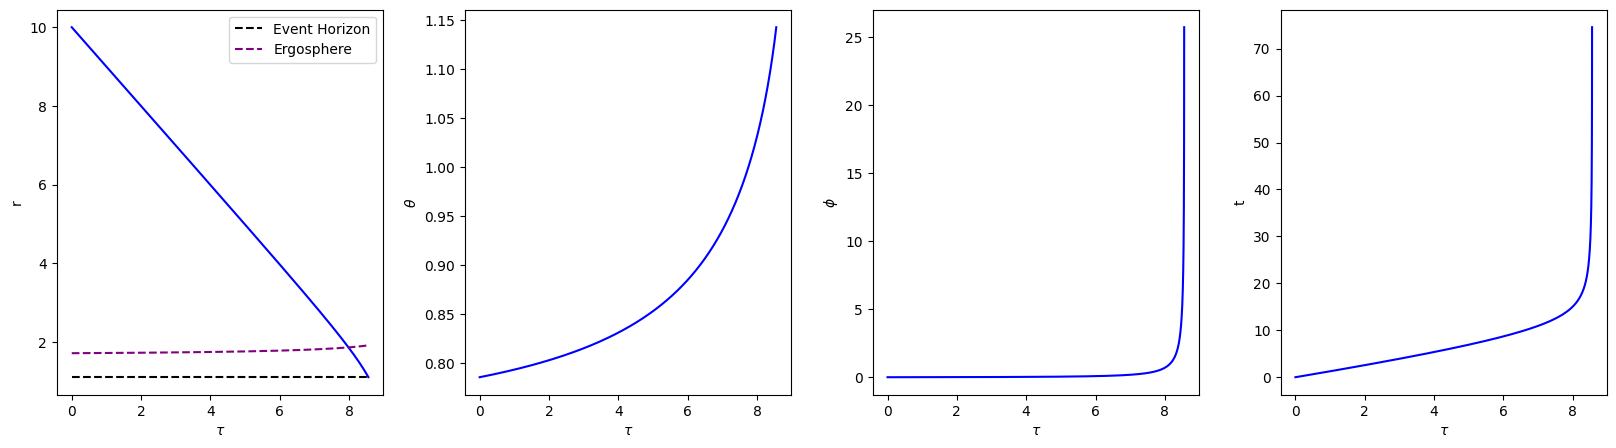

In [167]:
# plot_coords(alice, pos_alice, tau_alice)
plot_coords(bob, pos_bob, tau_bob)

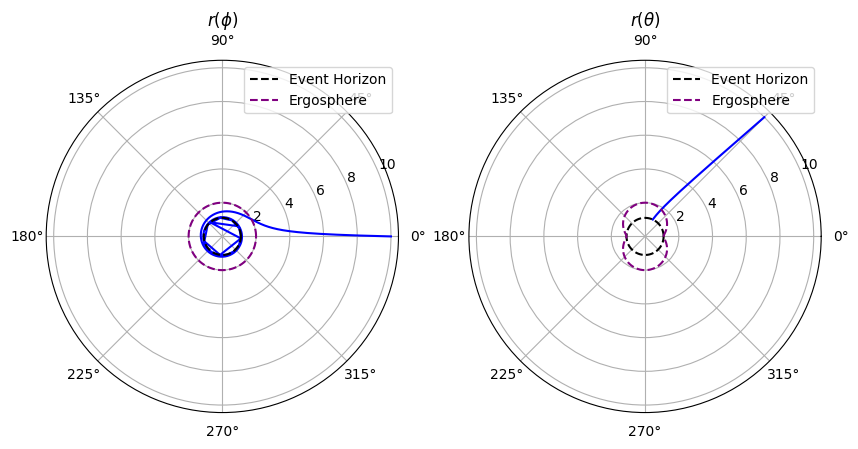

In [168]:
#plot_trajectory(alice, pos_alice, tau_alice)
plot_trajectory(bob, pos_bob, tau_bob)

MovieWriter imagemagick unavailable; using Pillow instead.


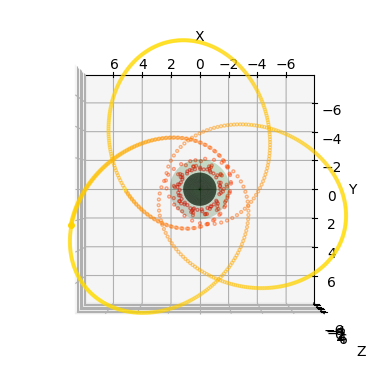

In [ ]:
animate(bob, pos_bob, tau_bob, trail_length = len(tau_bob), frames = 1000, filename = "zw_916235_2_995.gif")